# Potential Energy Surface of Hydrogen Molecule

Here, we explore the Potential Energy Surface of the Hydrogen Molecule $H_2$, for various bond lengths between 1 to 4 Bohr with an interval of 0.2 Bohr.

### PennyLane PES Implementation

In [1]:
# Native Lib
import itertools as it
import copy

# External Lib
import pennylane as qml
import numpy as np
from pennylane import numpy as plnp
import matplotlib.pyplot as plt

# qanything Lib
import qanything.get_index as getind
import qanything.get_molecule as getmol
import qanything.get_json as getjson

In [2]:
# Define the array of bond lenghts
step_size = 0.2
min_length = 1
max_length = 4
bond_length_arr = np.arange(min_length,max_length+step_size, step_size)

# Create Hydrogen Molecule
mol_name = 'h2'
mol_full_name = 'hydrogen molecule'

# Get Hydrogen Molecule
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr[0])

# Get the Molecular Hamiltonian (Using Jordan-Wigner)
mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

# Getting the Orbital and Excitation Index 
occupied_index, single_index, double_index = getind.generate_excite_index(num_qubits, num_elec)

# Get the Fermionic Disentangled Unitary Coupled Cluster Single Doubles (UCCSD) Excitation Order 
disentangle_order = getind.generate_disentanglement_order(occupied_index, single_index, double_index)

# Get the Hartree-Fock State
hf = qml.qchem.hf_state(electrons=num_elec, orbitals=num_qubits)

# Prepare the UCCSD Ansatz based on the Disentangled Order
def uccsd_ansatz(params, wires, excitations):
    qml.BasisState(hf, wires=wires)
    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)

# Prepare a device and optimiser
dev = qml.device("default.qubit", wires=num_qubits)
optimiser_list = [qml.RMSPropOptimizer(), 
qml.AdamOptimizer(), 
qml.NesterovMomentumOptimizer(), 
qml.MomentumOptimizer(), 
qml.QNGOptimizer(), 
qml.AdagradOptimizer(), 
qml.GradientDescentOptimizer(), ]
optimiser_list_str = ['qml.RMSPropOptimizer()', 
'qml.AdamOptimizer()', 
'qml.NesterovMomentumOptimizer()', 
'qml.MomentumOptimizer()', 
'qml.QNGOptimizer()', 
'qml.AdagradOptimizer()', 
'qml.GradientDescentOptimizer()', ]
max_steps = 100

/Users/cheechonghian/miniconda3/envs/mypenny/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
# Get Morse Curve
hf_energy = np.zeros(len(bond_length_arr))
vqe_uccsd_energy = np.zeros(len(bond_length_arr))
vqe_params = []
vqe_energy_hist = []
vqe_params_hist = []

for bond_iter in range(len(bond_length_arr)):
    print(f"Bond Length: {bond_length_arr[bond_iter]}")
    if bond_iter != 0:
        # Get Hydrogen Molecule at a different bond length
        mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr[bond_iter])
        mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

    # Prepare Cost Function
    cost_fn = qml.ExpvalCost(uccsd_ansatz, mol_ham, dev, optimize=True)

    # Set Initial Parameters
    params = plnp.zeros(len(disentangle_order), requires_grad=True)
    params_hist = [params]
    energy_hist = []
    check_switch = True
    opt_iter = 0
    optimiser = optimiser_list[0]  # Get the first optimiser
    # Perform VQE
    for step in range(max_steps):
        params, energy = optimiser.step_and_cost(cost_fn, params, excitations=disentangle_order)
        if step != 0:
            if check_switch and energy > energy_hist[-1]:
                opt_iter += 1
                params_hist.pop()  # Remove the last param that corresponds to the increased energy
                energy_hist.pop()  # Remove the increased energy
                params = params_hist[-1]
                if opt_iter >= (len(optimiser_list)-1):
                    opt_iter = len(optimiser_list)-1
                    check_switch = False
                optimiser = optimiser_list[opt_iter]
                print(f"Iter: {step}, Switching Optimiser to : {optimiser_list_str[opt_iter]}")
            
            else:
                energy_hist.append(energy)
                params_hist.append(params)
                print(f"Iter: {step}, Energy: {energy}")
        
        else:
            energy_hist.append(energy)
            params_hist.append(params)
            print(f"Iter: {step}, Energy: {energy}")
    
    # Get the minimum point
    hf_energy[bond_iter] += energy_hist[0]
    min_energy_ind = np.argmin(np.asarray(energy_hist))
    vqe_uccsd_energy[bond_iter] += energy_hist[min_energy_ind]
    vqe_params.append(params_hist[min_energy_ind])
    
    vqe_energy_hist.append(energy_hist)
    vqe_params_hist.append(params_hist)

Bond Length: 1.0
Iter: 0, Energy: -1.0659994621315834
Iter: 1, Energy: -1.0708267285990885
Iter: 2, Energy: -1.0733361539059167
Iter: 3, Energy: -1.0749444207216428
Iter: 4, Energy: -1.076058178275322
Iter: 5, Energy: -1.0768582237113904
Iter: 6, Energy: -1.0774432343807008
Iter: 7, Energy: -1.077874060801695
Iter: 8, Energy: -1.0781913534370355
Iter: 9, Energy: -1.0783652661001335
Iter: 10, Energy: -1.0783710121978294
Iter: 11, Energy: -1.0786861878477252
Iter: 12, Energy: -1.0787965545250524
Iter: 13, Energy: -1.0788587572733
Iter: 14, Energy: -1.0788994821645663
Iter: 15, Energy: -1.0789263101592104
Iter: 16, Energy: -1.0789436334352582
Iter: 17, Energy: -1.0789545233327176
Iter: 18, Energy: -1.0789611644401556
Iter: 19, Energy: -1.0789650819652201
Iter: 20, Energy: -1.0789673106393995
Iter: 21, Energy: -1.0789685290537707
Iter: 22, Energy: -1.0789691652752844
Iter: 23, Energy: -1.0789694764810722
Iter: 24, Energy: -1.0789696036169976
Iter: 25, Switching Optimiser to : qml.AdamOptim

In [4]:
# We get these reference energy values by running Psi4 Ab Initio Computational Quantum Chemistry Calculation
h2_fci_energy = np.array([-1.0789697691977391,
 -1.1266988216562037,
 -1.1372759436170639,
 -1.1288156436492498,
 -1.1108459773448578,
 -1.0884963081469063,
 -1.064739347320966,
 -1.0414893384075863,
 -1.0200239217388245,
 -1.0011251641870715,
 -0.9851568243679125,
 -0.9721473744115001,
 -0.9618847058303381,
 -0.9540122160448633,
 -0.9481138649481352,
 -0.9437784716239599])

### Results

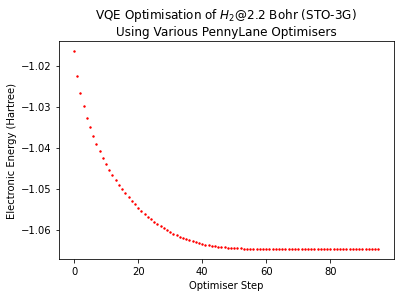

In [31]:
# Plotting the Energy Optimiser Steps
fig4, ax4 = plt.subplots()
i = 6
ax4.scatter(np.arange(len(vqe_energy_hist[i])),vqe_energy_hist[i], color='r', s=2)
ax4.set_xlabel('Optimiser Step')
ax4.set_ylabel('Electronic Energy (Hartree)')
ax4.set_title(r'VQE Optimisation of $H_2$'+'@{:.1f} Bohr (STO-3G)'.format(bond_length_arr[i])+f'\nUsing Various PennyLane Optimisers')
fig.savefig('h2_morse_vqe_opt_penny.png',format='png')

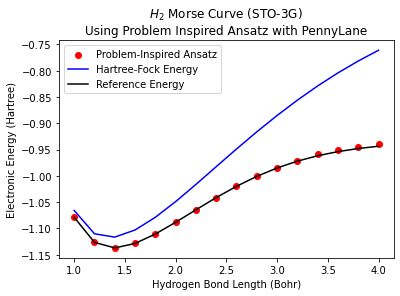

In [25]:
fig, ax = plt.subplots()
ax.scatter(bond_length_arr,vqe_uccsd_energy, label='Problem-Inspired Ansatz', color='r')
ax.plot(bond_length_arr,hf_energy, label='Hartree-Fock Energy',color='b')
ax.plot(bond_length_arr,h2_fci_energy,label='Reference Energy', color='k')
ax.set_xlabel('Hydrogen Bond Length (Bohr)')
ax.set_ylabel('Electronic Energy (Hartree)')
ax.set_title(r'$H_2$ Morse Curve (STO-3G)'+f'\nUsing Problem Inspired Ansatz with PennyLane')
ax.legend()
fig.savefig('h2_morse_penny.png',format='png')

### Discussion

Expectedly, the plot show a good agreement of estimate energy values obtained from our Problem Inspired Ansatz to the reference energy calculated from [Psi4](
Psi4https://psicode.org) Ab Initio Computational Quantum Chemistry Calculation. The minimum is at 1.4 Bohr with -1.137275941 Hartree which is close to the reference of -1.13727594 Hartree up to the $8^{th}$ decimal place.

In [29]:
# save_data = {}
# save_data['header_names'] = ['bond_length', 'fci_ref_energy', 'hf_ref_energy', 'vqe_uccsd_energy', 'vqe_params', 'vqe_energy_hist', 'vqe_params_hist', ]
# save_data['bond_length'] = bond_length_arr
# save_data['fci_ref_energy'] = h2_fci_energy
# save_data['hf_ref_energy'] = hf_energy
# save_data['vqe_uccsd_energy'] = vqe_uccsd_energy
# save_data['vqe_params'] = vqe_params
# save_data['vqe_energy_hist'] = vqe_energy_hist
# save_data['vqe_params_hist'] = vqe_params_hist
# getjson.save_to_json('h2_morse_vqe_A.json',save_data)

Saving Data to: h2_morse_vqe_A.json


### Qamuy PES Implementation

In [33]:
import qamuy.chemistry as qy
from qamuy.client import Client


In [34]:
# Define the array of bond lenghts
step_size = 0.2
min_length = 1
max_length = 4
bond_length_arr = 0.529177249 * np.arange(min_length,max_length+step_size, step_size)  # Convert to Angstroms

# Create Hydrogen Molecule
mol_name = 'h2'
mol_full_name = 'hydrogen molecule'

# Get Hydrogen Molecule
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length_arr[0])
new_coords = coords.reshape((2,3)).tolist()
setting = qy.QamuyChemistryInput()
molecule = setting.target_molecule
molecule.geometry = qy.molecule_geometry(mol_symbols, new_coords)
molecule.basis = "sto-3g"
molecule.multiplicity = 1
molecule.num_excited_states = 0

# Set Fermion to Spin Mapping
setting.mapping.type = "JORDAN_WIGNER"

# Set Quantum Algorithm 
setting.solver.type = "VQE"

# Set cost function
setting.cost_function.type = "NONE"

# Set ansatz
setting.ansatz.type = "UCCSD"
setting.ansatz.trotter_steps = 1
setting.ansatz.reference_state = 'RHF'
setting.ansatz.initial_parameter = [0]
setting.ansatz.use_random_initial_guess = False

# My Optimiser
setting.optimizer.type = "BFGS"

# Quantum Device
setting.quantum_device.type = "EXACT_SIMULATOR"

# Ab Inito Calculation For Reference
setting.post_hf_methods.append(qy.PostHFMethod(type="FCI"))

In [35]:
# Prepare Inputs for Jobs Submission
jobs = []
for distance in bond_length_arr:
    new_input = copy.deepcopy(setting)
    mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, distance)
    new_coords = coords.reshape((2,3)).tolist()
    new_input.target_molecule.geometry = qy.molecule_geometry(mol_symbols, new_coords)
    jobs.append(client.submit(new_input))

In [36]:
# Submit Jobs for computation
results = client.wait_and_get_job_results(jobs)
outputs = [res.output for res in results]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:   43.9s remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:  1.2min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:  1.7min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:  2.3min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  3.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:  4.3min remaining:   59.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  5.7min finished


### Results

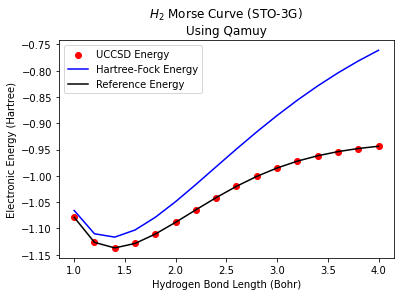

In [37]:
# Collate the Results
hf_energy_qamuy = np.zeros(len(bond_length_arr))
ref_energy_qamuy = np.zeros(len(bond_length_arr))
uccsd_energy_qamuy = np.zeros(len(bond_length_arr))
for i in range(len(bond_length_arr)):
    hf_energy_ = outputs[i].molecule_result.hf_result.evaluated_properties[0].energy.values[0].value
    ref_energy = outputs[i].molecule_result.post_hf_results[0].evaluated_properties[0].energy.values[0].value
    uccsd_energy = outputs[i].molecule_result.quantum_device_result.evaluated_properties[0].energy.values[0].value
    hf_energy_qamuy[i] = hf_energy_
    ref_energy_qamuy[i] = ref_energy
    uccsd_energy_qamuy[i] = uccsd_energy

# Plot the Results
fig2, ax2 = plt.subplots()
ax2.scatter(bond_length_arr/0.529177249,uccsd_energy_qamuy, label='UCCSD Energy', color='r')
ax2.plot(bond_length_arr/0.529177249,hf_energy_qamuy, label='Hartree-Fock Energy', color='b')
ax2.plot(bond_length_arr/0.529177249,ref_energy_qamuy, label='Reference Energy', color='k')
ax2.set_xlabel("Hydrogen Bond Length (Bohr)")
ax2.set_ylabel("Electronic Energy (Hartree)")
ax2.set_title(r"$H_2$ Morse Curve (STO-3G)"+f"\nUsing Qamuy")
ax2.legend()
fig2.savefig('h2_morse_qamuy.png',format='png')

In [39]:
min(ref_energy_qamuy)

-1.1372759430838784

### Dicussion

Hardly unsurprising, Qamuy's Morse Curve has a in the minimum at 1.4 Bohr with -1.1372759430838761 Hartree which is exactly close reference of -1.1372759430838784 Hartree up to the $14^{th}$ decimal place, almost machine precision. 

In [ ]:
# save_data = {}
# save_data['header_names'] = ['bond_length', 'fci_ref_energy', 'hf_ref_energy', 'vqe_uccsd_energy',]
# save_data['bond_length'] = bond_length_arr
# save_data['fci_ref_energy'] = ref_energy_qamuy
# save_data['hf_ref_energy'] = hf_energy_qamuy
# save_data['vqe_uccsd_energy'] = uccsd_energy_qamuy
# getjson.save_to_json('h2_morse_vqe_qamuy_A.json',save_data)